In [1]:
import pandas as pd
import gzip
import json
import math
import matplotlib.pyplot as plt
from zipfile import ZipFile
from datetime import datetime
import glob
import os
import math
from ipywidgets import IntProgress
from IPython.display import display
import seaborn as sns
import numpy as np
from multiprocessing import Manager
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from matplotlib import rc
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import auc,confusion_matrix,roc_auc_score,roc_curve,precision_score,recall_score,f1_score,accuracy_score

In [3]:
df = pd.read_csv('/Users/alexislacabane/Documents/NewsPill/archive/input_data.csv').round(2)
df = df.set_index(df.user_id).drop('user_id',axis=1)
# forecast_score_7 is showing inf and NaN values
df.forecast_score_7 = 0
print(df.shape)
print('60/515')

(575, 36)
60/515


In [5]:
df

,forecast_score_1,read_score_1,wallet_score_1,age_score_1,sum_score_1,forecast_score_2,read_score_2,wallet_score_2,age_score_2,sum_score_2,forecast_score_3,read_score_3,wallet_score_3,age_score_3,sum_score_3,forecast_score_4,read_score_4,wallet_score_4,age_score_4,sum_score_4,forecast_score_5,read_score_5,wallet_score_5,age_score_5,sum_score_5,forecast_score_6,read_score_6,wallet_score_6,age_score_6,sum_score_6,forecast_score_7,read_score_7,wallet_score_7,age_score_7,sum_score_7,churn
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3493037190737583,0.0,0.8,0.0,0.1,0.9,0.00,0.75,0.0,0.08,0.83,0.00,0.67,0.00,0.06,0.73,0.00,0.50,0.00,0.04,0.54,0.0,0.5,0.0,0.04,0.54,0.0,0.5,0.0,0.04,0.54,0,0.0,0.0,0.02,0.02,1
2950476651671903,0.0,0.6,0.0,0.1,0.7,0.00,0.50,0.0,0.08,0.58,0.00,0.67,0.00,0.06,0.73,0.00,0.50,0.00,0.04,0.54,0.0,0.5,0.0,0.04,0.54,0.0,0.5,0.0,0.04,0.54,0,0.0,0.0,0.02,0.02,1
2721803727912660,0.0,0.8,0.0,0.1,0.9,0.00,0.75,0.0,0.08,0.83,0.00,0.67,0.00,0.06,0.73,0.00,0.50,0.00,0.04,0.54,0.0,0.5,0.0,0.04,0.54,0.0,0.5,0.0,0.04,0.54,0,1.0,0.0,0.02,1.02,1
2922919451075156,0.2,1.0,0.0,0.1,1.3,0.00,1.00,0.0,0.08,1.08,0.00,1.00,0.00,0.06,1.06,0.00,1.00,0.00,0.04,1.04,0.0,1.0,0.0,0.04,1.04,0.0,0.5,0.0,0.04,0.54,0,0.0,0.0,0.02,0.02,1
3351769908228693,0.2,0.2,0.0,0.1,0.5,0.25,0.25,0.0,0.08,0.58,0.33,0.33,0.00,0.06,0.73,0.50,0.50,0.00,0.04,1.04,0.5,0.5,0.0,0.04,1.04,0.5,0.5,0.0,0.04,1.04,0,0.0,0.0,0.02,0.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000829849930909,0.0,0.0,0.0,0.1,0.1,0.00,0.00,0.0,0.10,0.10,0.00,0.00,0.00,0.08,0.08,0.00,0.00,0.00,0.06,0.06,0.0,0.0,0.0,0.04,0.04,0.0,0.0,0.0,0.02,0.02,0,0.0,0.0,0.00,0.00,0
4070102539673974,1.0,1.0,0.0,0.1,2.1,1.00,1.00,0.0,0.10,2.10,1.00,1.00,0.00,0.08,2.08,1.00,1.00,0.00,0.06,2.06,1.0,1.0,0.0,0.04,2.04,1.0,1.0,0.0,0.02,2.02,0,0.0,0.0,0.00,0.00,0
4078461412171433,0.2,0.4,0.0,0.1,0.7,0.20,0.40,0.0,0.10,0.70,0.00,0.25,0.00,0.08,0.33,0.00,0.33,0.00,0.06,0.39,0.0,0.5,0.0,0.04,0.54,0.0,0.0,0.0,0.02,0.02,0,0.0,0.0,0.00,0.00,0


In [16]:
# Reduce mutlticolinearity
for i in df.index:
    if df[f'forecast_score_1'][i]==0:
        df[f'forecast_score_1'][i] = 1
    if df[f'read_score_1'][i]==0:
        df[f'read_score_1'][i] = 1
    if df[f'wallet_score_1'][i]==0:
        df[f'wallet_score_1'][i] = 1
    if df[f'age_score_1'][i]==0:
        df[f'age_score_1'][i] = 1
    for j in range(2,8):
            df[f'forecast_score_{j}'][i] = df[f'forecast_score_{j}'][i]/df[f'forecast_score_1'][i]
            df[f'read_score_{j}'][i] = df[f'read_score_{j}'][i]/df[f'read_score_1'][i]
            df[f'wallet_score_{j}'][i] = df[f'wallet_score_{j}'][i]/df[f'wallet_score_1'][i]
            df[f'age_score_{j}'][i] = df[f'age_score_{j}'][i]/df[f'age_score_1'][i]
            df[f'sum_score_{j}'][i] = df[f'sum_score_{j}'][i]/df[f'sum_score_1'][i]

In [17]:
df.head()

,forecast_score_1,read_score_1,wallet_score_1,age_score_1,sum_score_1,forecast_score_2,read_score_2,wallet_score_2,age_score_2,sum_score_2,forecast_score_3,read_score_3,wallet_score_3,age_score_3,sum_score_3,forecast_score_4,read_score_4,wallet_score_4,age_score_4,sum_score_4,forecast_score_5,read_score_5,wallet_score_5,age_score_5,sum_score_5,forecast_score_6,read_score_6,wallet_score_6,age_score_6,sum_score_6,forecast_score_7,read_score_7,wallet_score_7,age_score_7,sum_score_7,churn
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3493037190737583,1.0,0.8,1.0,0.1,0.9,0.00,0.937500,0.0,0.8,0.922222,0.00,0.837500,0.0,0.6,0.811111,0.0,0.625000,0.0,0.4,0.600000,0.0,0.625000,0.0,0.4,0.600000,0.0,0.625000,0.0,0.4,0.600000,0,0.00,0.0,0.2,0.022222,1
2950476651671903,1.0,0.6,1.0,0.1,0.7,0.00,0.833333,0.0,0.8,0.828571,0.00,1.116667,0.0,0.6,1.042857,0.0,0.833333,0.0,0.4,0.771429,0.0,0.833333,0.0,0.4,0.771429,0.0,0.833333,0.0,0.4,0.771429,0,0.00,0.0,0.2,0.028571,1
2721803727912660,1.0,0.8,1.0,0.1,0.9,0.00,0.937500,0.0,0.8,0.922222,0.00,0.837500,0.0,0.6,0.811111,0.0,0.625000,0.0,0.4,0.600000,0.0,0.625000,0.0,0.4,0.600000,0.0,0.625000,0.0,0.4,0.600000,0,1.25,0.0,0.2,1.133333,1
2922919451075156,0.2,1.0,1.0,0.1,1.3,0.00,1.000000,0.0,0.8,0.830769,0.00,1.000000,0.0,0.6,0.815385,0.0,1.000000,0.0,0.4,0.800000,0.0,1.000000,0.0,0.4,0.800000,0.0,0.500000,0.0,0.4,0.415385,0,0.00,0.0,0.2,0.015385,1
3351769908228693,0.2,0.2,1.0,0.1,0.5,1.25,1.250000,0.0,0.8,1.160000,1.65,1.650000,0.0,0.6,1.460000,2.5,2.500000,0.0,0.4,2.080000,2.5,2.500000,0.0,0.4,2.080000,2.5,2.500000,0.0,0.4,2.080000,0,0.00,0.0,0.2,0.040000,1


In [22]:
# Test multicolinearity but we except and keep high VIFs

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
# Test VIF for mutlticolinearity
X = df.drop(['churn'],axis=1)
pd.Series([VIF(X.values, i) for i in range(X.shape[1])],index=X.columns).sort_values(ascending=False)

sum_score_3         1989.085525
sum_score_2         1653.799387
sum_score_4         1233.648673
read_score_3        1150.530292
age_score_2          765.792769
read_score_4         755.526732
sum_score_5          656.678058
age_score_3          641.964813
read_score_2         613.820966
age_score_4          434.328276
sum_score_1          427.657793
read_score_5         420.908429
read_score_6         236.365567
age_score_1          232.526272
age_score_5          186.809375
read_score_1         161.968241
forecast_score_1     159.066925
wallet_score_1       156.957257
sum_score_6          152.874009
forecast_score_2     137.921208
wallet_score_2        62.589120
forecast_score_3      56.578788
forecast_score_4      46.046714
forecast_score_5      29.608181
age_score_6           27.308486
wallet_score_3        20.052856
sum_score_7           15.529679
wallet_score_4        15.365562
forecast_score_6      12.209961
wallet_score_5        11.326000
read_score_7          10.190358
age_scor

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn',axis=1),df.churn,test_size=1/3,random_state=42)

## Logic models

In [65]:
model1 = LogisticRegression()
res1 = model1.fit(X_train,y_train)
pred1 = model1.predict(X_test)
conf1 = confusion_matrix(y_test,pred1)
conf1

array([[174,   0],
       [  7,  11]])

In [66]:
recall_score(y_test,pred1)

0.6111111111111112

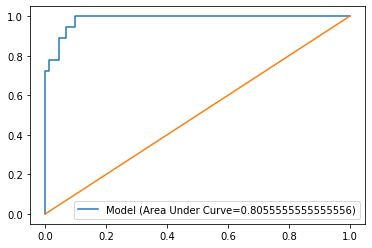

In [62]:
model1_roc=roc_auc_score(y_test,pred1)
fpr,tpr,thresholds=roc_curve(y_test, model1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label=f'Model (Area Under Curve={model1_roc})')
plt.plot([0,1],[0,1])
plt.legend()
plt.show()

In [69]:
model1 = LogisticRegression(class_weight='balanced')
res1 = model1.fit(X_train,y_train)
pred1 = model1.predict(X_test)
conf1 = confusion_matrix(y_test,pred1)
conf1

array([[163,  11],
       [  1,  17]])

In [70]:
recall_score(y_test,pred1)

0.9444444444444444

In [72]:
model1_roc

0.9406130268199234

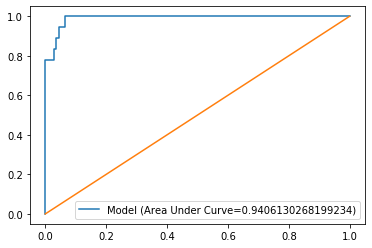

In [71]:
model1_roc=roc_auc_score(y_test,pred1)
fpr,tpr,thresholds=roc_curve(y_test, model1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label=f'Model (Area Under Curve={model1_roc})')
plt.plot([0,1],[0,1])
plt.legend()
plt.show()

## Naive Bayes model

In [36]:
model2 = GaussianNB()
res2 = model2.fit(X_train,y_train)
pred2 = model2.predict(X_test)
conf2 = confusion_matrix(y_test,pred2)
conf2

array([[174,   0],
       [  0,  18]])

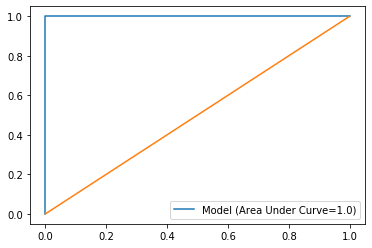

In [38]:
model2_roc=roc_auc_score(y_test,pred2)
fpr,tpr,thresholds=roc_curve(y_test, model2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label=f'Model (Area Under Curve={model2_roc})')
plt.plot([0,1],[0,1])
plt.legend()
plt.show()

## Decision Tree model

In [55]:
model3 = DecisionTreeClassifier(class_weight='balanced')
res3 = model3.fit(X_train,y_train)
pred3 = model3.predict(X_test)
conf3 = confusion_matrix(y_test,pred3)
conf3

array([[174,   0],
       [  0,  18]])

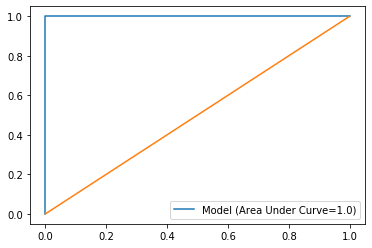

In [56]:
model3_roc=roc_auc_score(y_test,pred3)
fpr,tpr,thresholds=roc_curve(y_test, model3.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label=f'Model (Area Under Curve={model3_roc})')
plt.plot([0,1],[0,1])
plt.legend()
plt.show()

## XGBoost Model

In [58]:
model4 = XGBClassifier()
res4 = model4.fit(X_train,y_train)
pred4 = model4.predict(X_test)
conf4 = confusion_matrix(y_test,pred4)
conf4

array([[174,   0],
       [  0,  18]])

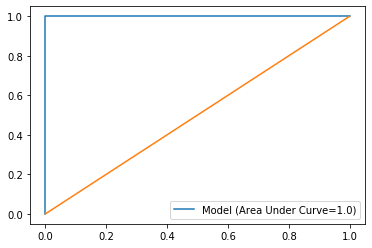

In [59]:
model4_roc=roc_auc_score(y_test,pred4)
fpr,tpr,thresholds=roc_curve(y_test, model4.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label=f'Model (Area Under Curve={model4_roc})')
plt.plot([0,1],[0,1])
plt.legend()
plt.show()

## Final model - LogisticRegression(class_weight='balanced')

In [73]:
recall_score(y_test,pred1)

0.9444444444444444

In [74]:
model1_roc

0.9406130268199234